In [31]:
import requests
import shutil
import psycopg2
import os
import random
import pandas as pd
import numpy as np
import requests
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from io import BytesIO
from tqdm import tqdm
from dotenv import load_dotenv
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model, Sequential, model_from_json, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix, roc_curve, auc, RocCurveDisplay, f1_score


In [2]:
load_dotenv()
postgres_password = os.getenv('POSTGRES_PASSWORD')
postgres_port_no = os.getenv('POSTGRES_PORT_NO')
host = os.getenv('POSTGRES_HOST')
database = os.getenv('POSTGRES_DB')
user = os.getenv('POSTGRES_USER')


def create_df():
    try:
        conn = psycopg2.connect(
            host=host,
            user=user,
            password=postgres_password,
            port=postgres_port_no,
            database=database)
        query = "SELECT * FROM PRODUCTS"
        # Read data from the database into a DataFrame
        df = pd.read_sql(query, con=conn)
        return df
    except Exception as e:
        print("An error occurred:", e)
        conn.rollback()  # Rollback in case of error
    finally:
        conn.close()  # Close the connection
# Display the DataFrame
amazon = create_df()

## Develop an image-based search feature for visually similar products

- Begin by downloading the product images using the URLs provided in the `img_link` for processing

- Feature Extraction. The VGG16 model, a pre-trained convolutional neural network, is used to embed the images. This model helps extract high-level features from the images, converting them into a numerical representation suitable for comparison.

Cosine similarity is a measure of the angle between two vectors. It is computed by taking the dot product of the vectors and dividing it by the product of their magnitudes. This metric is not affected by the size of the vector but only by the angle between them. This means that vectors with large or small values will have the same cosine similarity as long as they point in the same direction.


​


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.output)


def get_image_embedding_from_url(url):
    """Fetch an image from a URL, preprocess it, and extract VGG16 embeddings."""
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()  # Raise exception for HTTP errors

        # Load the image, resize it, and preprocess for VGG16
        img = Image.open(BytesIO(response.content)).convert('RGB').resize((224, 224))
        img_array = np.array(img)[np.newaxis, ...]  # Add batch dimension
        img_array = preprocess_input(img_array)

        # Get the embedding from the model
        embedding = model.predict(img_array)
        return embedding.flatten()  # Flatten the embedding
    except Exception as e:
        print(f"Error fetching or processing {url}: {e}")
        return None

# Generate embeddings for all images in the DataFrame
amazon['embedding'] = amazon['img_link'].apply(get_image_embedding_from_url)

# Filter out rows with failed embeddings
amazon = amazon[amazon['embedding'].notnull()]


A K-Nearest Neighbors (KNN) model, leveraging cosine similarity, is used to measure the distance between the embedded images. 

This efficiently identify and recommend visually similar products based on the features extracted from the images.


In [45]:
# Prepare embeddings and KNN model
embeddings = np.vstack(amazon['embedding'].values)
knn = NearestNeighbors(n_neighbors=5, metric='cosine')  # Use cosine similarity
knn.fit(embeddings)

# Saving the fitted KNN model
knnPickle = open('knn_pickle_file', 'wb')     
pickle.dump(knn, knnPickle)  
# close the file
knnPickle.close()


def get_image_from_url(url):
    """Fetch and return an image from the given URL."""
    try:
        response = requests.get(url)
        response.raise_for_status()
        return Image.open(BytesIO(response.content))
    except Exception as e:
        print(f"Error fetching image from {url}: {e}")
        return None

def find_similar_images(test_img_url, knn_model, k=5):
    """Find k similar images to the test image using KNN."""
    test_embedding = get_image_embedding_from_url(test_img_url)
    if test_embedding is None:
        print("Failed to generate embedding for the test image.")
        return None, None

    distances, indices = knn_model.kneighbors([test_embedding], n_neighbors=k)
    return distances[0], indices[0]

# Plot input and similar images
def plot_images(test_img_url, similar_images, distances):
    n = len(similar_images) + 1  # Test image + similar images
    fig, axes = plt.subplots(1, n, figsize=(15, 5))

    # Plot the test image
    test_img = get_image_from_url(test_img_url)
    if test_img:
        axes[0].imshow(test_img)
        axes[0].set_title("Input Image")
        axes[0].axis('off')

    # Plot the similar images
    for i, (img_url, dist) in enumerate(similar_images):
        img = get_image_from_url(img_url)
        if img:
            axes[i + 1].imshow(img)
            axes[i + 1].set_title(f"Dist: {dist:.2f}")
            axes[i + 1].axis('off')

    plt.show()

# Test with a new image
def display_similar_images(test_img_url):
    distances, indices = find_similar_images(test_img_url, knn)
    if distances is not None:
        similar_images = [(amazon.iloc[idx]['img_link'], dist) for idx, dist in zip(indices, distances)]
        return plot_images(test_img_url, similar_images, distances)

## Testing new images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


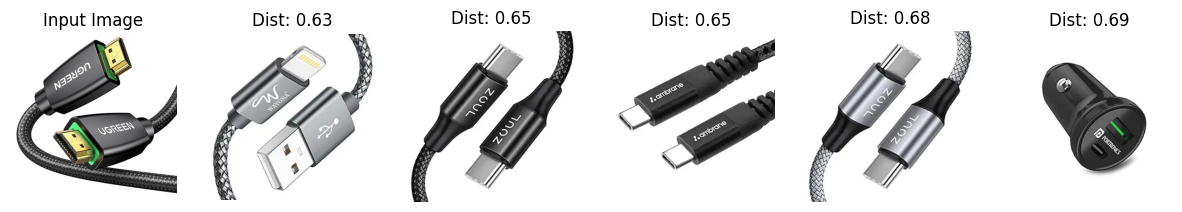

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


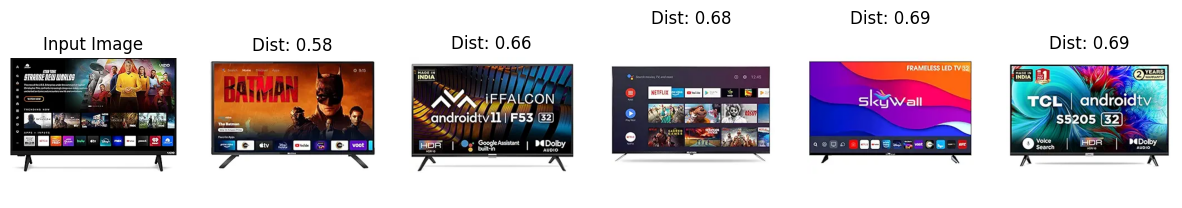

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


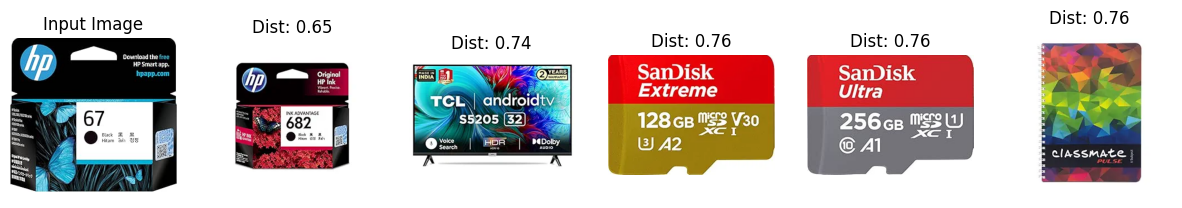

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


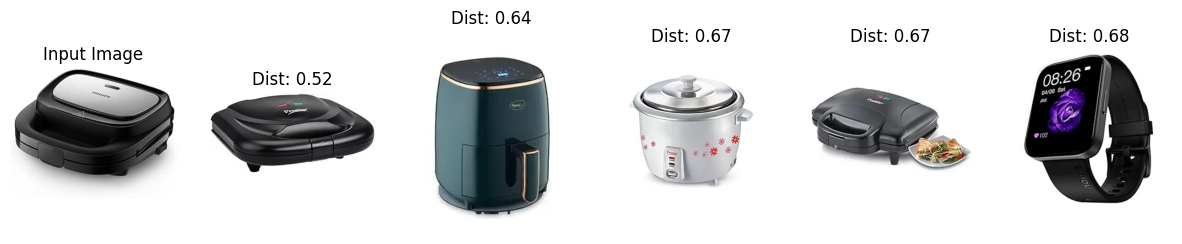

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


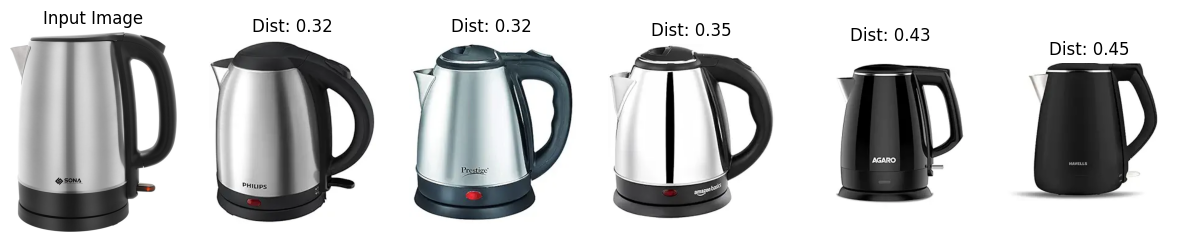

In [46]:
display_similar_images("https://m.media-amazon.com/images/I/71dRiUIBZjL._SX522_.jpg")
display_similar_images("https://m.media-amazon.com/images/I/81R3dLptKcL.__AC_SX300_SY300_QL70_FMwebp_.jpg")
display_similar_images("https://m.media-amazon.com/images/I/716ZH17VpBL.__AC_SY300_SX300_QL70_ML2_.jpg")
display_similar_images("https://m.media-amazon.com/images/I/51cW0XzyBPL.__AC_SX300_SY300_QL70_ML2_.jpg")
display_similar_images("https://m.media-amazon.com/images/I/71qUKVBBVpL._AC_SX679_.jpg")

# Implement automatic product categorization based on image features


Base Category Distribution:


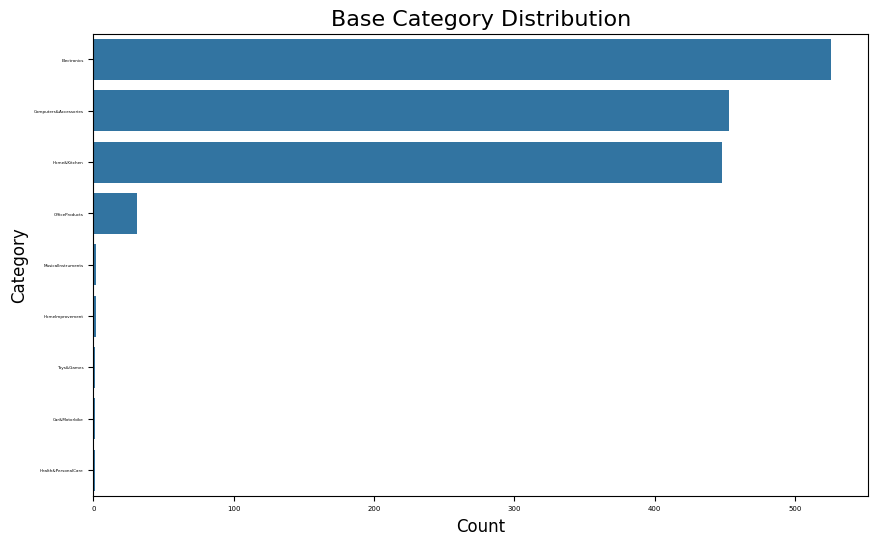

Second Sub-Category Distribution:


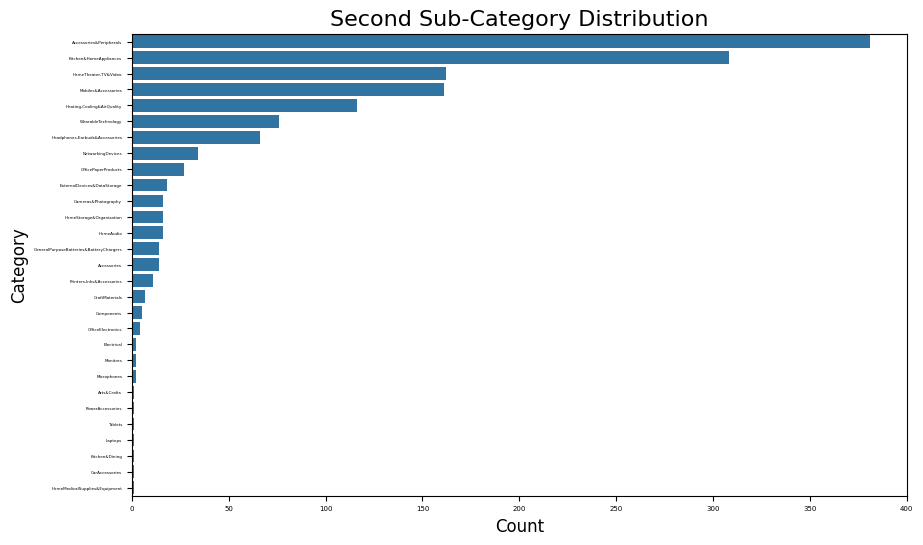

Third Sub-Category Distribution:


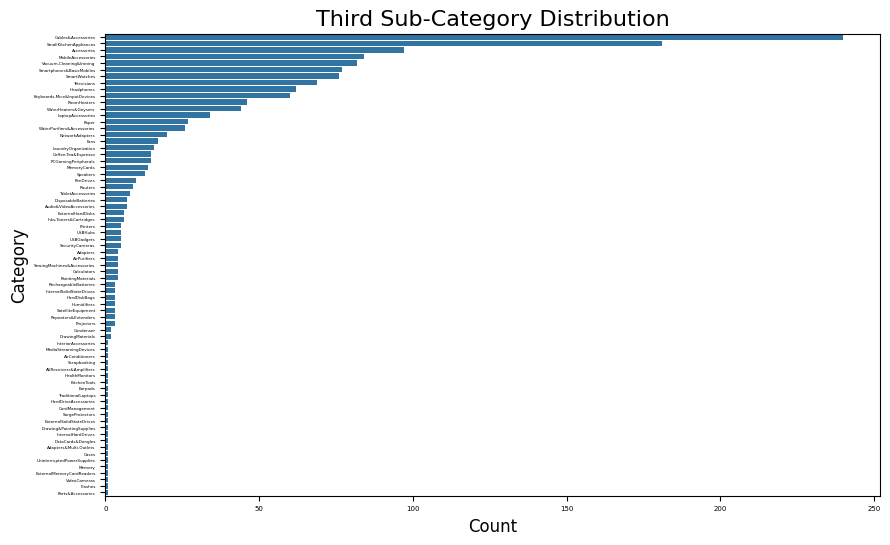

Fourth Sub-Category Distribution:


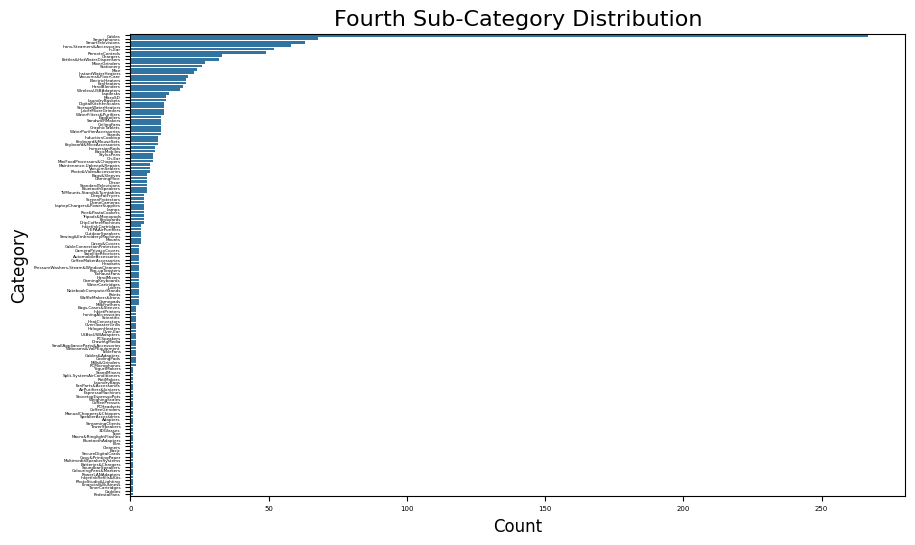

Fifth Sub-Category Distribution:


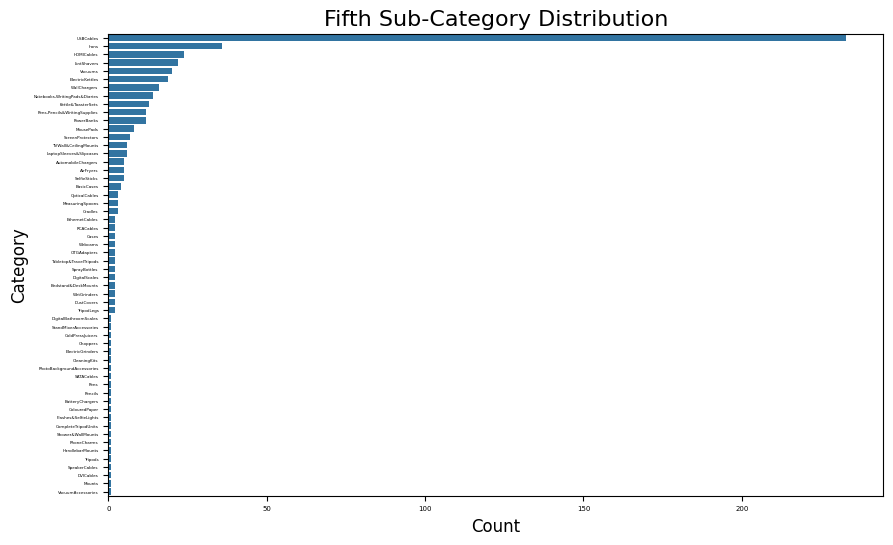

Last Category Distribution:


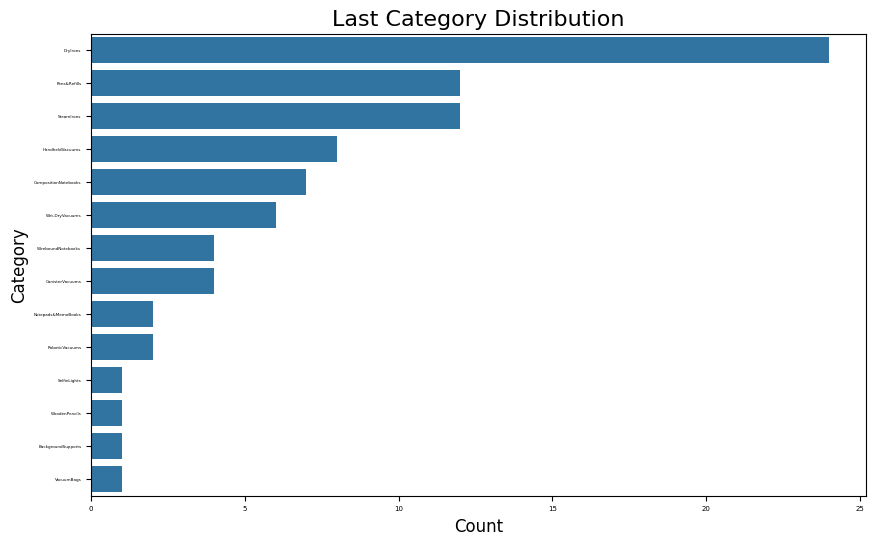

In [5]:
amazon = pd.read_csv('../data/source/amazon.csv')
amazon["base_category"] = amazon["category"].str.split("|").str[0]
amazon["second_sub_category"] = amazon["category"].str.split("|").str[1]
amazon["third_sub_category"] = amazon["category"].str.split("|").str[2]
amazon["fourth_sub_category"] = amazon["category"].str.split("|").str[3]
amazon["fifth_sub_category"] = amazon["category"].str.split("|").str[4]
amazon["last_category"] = amazon["category"].str.split("|").str[5]

# Calculate distribution for each category level
base_category_counts = amazon['base_category'].value_counts()
second_sub_category_counts = amazon['second_sub_category'].value_counts()
third_sub_category_counts = amazon['third_sub_category'].value_counts()
fourth_sub_category_counts = amazon['fourth_sub_category'].value_counts()
fifth_sub_category_counts = amazon['fifth_sub_category'].value_counts()
last_category_counts = amazon['last_category'].value_counts()

# Helper function to plot the distributions
def plot_category_distribution(category_counts, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=category_counts.values, y=category_counts.index)
    plt.title(title, fontsize=16)
    plt.xticks(fontsize=5)  # Adjust font size of x-axis tick labels
    plt.xlabel('Count', fontsize=12)
    plt.ylabel('Category', fontsize=12)
    plt.yticks(fontsize=3)  # Adjust font size of y-axis tick labels
    plt.show()

# Plotting each category level distribution
print("Base Category Distribution:")
plot_category_distribution(base_category_counts, "Base Category Distribution")

print("Second Sub-Category Distribution:")
plot_category_distribution(second_sub_category_counts, "Second Sub-Category Distribution")

print("Third Sub-Category Distribution:")
plot_category_distribution(third_sub_category_counts, "Third Sub-Category Distribution")

print("Fourth Sub-Category Distribution:")
plot_category_distribution(fourth_sub_category_counts, "Fourth Sub-Category Distribution")

print("Fifth Sub-Category Distribution:")
plot_category_distribution(fifth_sub_category_counts, "Fifth Sub-Category Distribution")

print("Last Category Distribution:")
plot_category_distribution(last_category_counts, "Last Category Distribution")

The above shows the different distribution of the each sub categories.
I have chosen to categories the dataset according to "Fourth Sub Category" due to the following reasons
- More categories with sufficient . In the "Fourth Sub-Category" distribution, we see many categories with higher counts. Categories with more samples (like "USB Cables" and "Cords") allow models to generalize better, reducing the risk of overfitting.
- Granularity and feature discrimination. The "Fourth Sub-Category" has more specific distinctions (e.g., "HDMI Cables", "Batteries", "Screen Protectors"), which may make it easier to associate distinct visual features with these categories.
    

Due to very imbalance dataset and very few training images for most categories, I set a threshold of 50 images and train a model to classify images into categories with more than or equal **50** images.

In [4]:
# Set the threshold (x) for the minimum category count
x = 50
mask = amazon['fourth_sub_category'].map(fourth_sub_category_counts) >= x

# # Apply the mask to filter the DataFrame
amazon = amazon[mask]

# # Display the filtered DataFrame
category_counts = amazon['fourth_sub_category'].value_counts()
print(category_counts)

fourth_sub_category
Cables                        267
Smartphones                    68
SmartTelevisions               63
Irons,Steamers&Accessories     58
In-Ear                         52
Name: count, dtype: int64


Downloading the images and storing it locally

In [ ]:
def download_images(df):
    # Dictionary to keep track of image counts for each subcategory
    image_count = {}

    for index, row in df.iterrows():
        # Ensure subcategory is a string to avoid TypeError
        sub_cat = str(row['fourth_sub_category']) if pd.notna(row['fourth_sub_category']) else "unknown"

        # Ensure img_url is valid and a string
        img_url = row.get('img_link', "")
        if not isinstance(img_url, str) or not img_url.startswith("http"):
            print(f"Invalid URL at index {index}: {img_url}")
            continue

        # Create the appropriate folder path
        folder_path = os.path.join('images', sub_cat)
        os.makedirs(folder_path, exist_ok=True)

        try:
            # Get the image content
            response = requests.get(img_url, timeout=10)
            response.raise_for_status()  # Raise an error for bad responses

            # Create a valid filename
            img_name = os.path.basename(img_url)
            img_path = os.path.join(folder_path, img_name)

            # Save the image
            with open(img_path, 'wb') as img_file:
                img_file.write(response.content)

            # Increment the count for this sub_cat
            if sub_cat not in image_count:
                image_count[sub_cat] = 0
            image_count[sub_cat] += 1

            print(f"Downloaded: {img_name} into /{sub_cat}")

        except Exception as e:
            print(f"Failed to download {img_url}: {e}")

    print("Image counts:", image_count)
# Example usage
download_images(amazon)


Due to invalid image urls, some images were unable to be downloaded.

### Image counts: 
'Cables': 148

'SmartTelevisions': 32

'Smartphones': 68

'In-Ear': 35

'Irons,Steamers&Accessories': 25


### Image Augmentation using `ImageDataGenerator` to handle imbalanced class

ImageDataGenerator applies random transformations to the images. The transformations include:
- Rotation: Random rotations within 40 degrees.
- Translation: Random horizontal and vertical shifts (up to 20%).
- Shearing: Distortion by 20 degrees.
- Zooming: Zooming in or out by 20%.
- Flipping: Random horizontal flips.
- Brightness: Adjusting brightness between 50% and 150%.
- Fill Mode: Filling missing pixels after transformations with nearest values.

In [72]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def augment_images(folder, target_count=2000):
    """
    Augment images in the input folder until the total count of images reaches approximately target_count.

    Parameters:
    - folder: path to the folder containing the images.
    - target_count: int, total number of images desired after augmentation.
    """
    img_count = len(os.listdir(folder))
    while img_count < target_count:
        # Load images
        images = []
        for filename in os.listdir(folder):
            if filename.endswith(('jpg', 'jpeg', 'png', 'bmp')):
                img_path = os.path.join(folder, filename)
                img = Image.open(img_path).convert('RGB')  # Ensure the image is in RGB format
                images.append(np.array(img))

        # Initialize the ImageDataGenerator
        datagen = ImageDataGenerator(
            rotation_range=40,          # Randomly rotate images in the range of 0 to 40 degrees
            width_shift_range=0.2,      # Randomly translate images horizontally by 20%
            height_shift_range=0.2,     # Randomly translate images vertically by 20%
            shear_range=0.2,            # Shear angle in counter-clockwise direction in degrees
            zoom_range=0.2,             # Randomly zoom in on images by 20%
            horizontal_flip=True,       # Randomly flip images horizontally
            brightness_range=(0.5, 1.5),# Randomly adjust brightness
            fill_mode='nearest'         # Fill in new pixels after transformations
        )

        # Current count of images
        current_count = len(images)

        # Generate augmented images
        for img in images:
            img = img.reshape((1, *img.shape))  # Reshape to (1, height, width, channels)
            
            i = 0
            # Generate augmented images
            for batch in datagen.flow(img, batch_size=1, save_to_dir=folder, 
                                    save_prefix='augmented', save_format='png'):
                i += 1
                if i >= 5:
                    break
            current_count += 5
            if current_count >= target_count:
                break
        img_count = len(os.listdir(folder))

    print(f'Total images after augmentation: {current_count}')


In [73]:
augment_images('images_aug_2K/Cables')
augment_images('images_aug_2K/In-Ear')
augment_images('images_aug_2K/Irons,Steamers&Accessories')
augment_images('images_aug_2K/Smartphones')
augment_images('images_aug_2K/SmartTelevisions')

Total images after augmentation: 2002
Total images after augmentation: 2004
Total images after augmentation: 2002
Total images after augmentation: 2004
Total images after augmentation: 2003


Randomly splitting the images of different categories into `train` and `test` folders

In [74]:
def split_data(base_dir, train_dir, test_dir, split_ratio=0.2):
    # Create train and test directories if they don't exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Get all categories (subdirectories) in the base directory
    categories = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

    for category in categories:
        category_path = os.path.join(base_dir, category)

        # Create directories for train and test
        train_category_path = os.path.join(train_dir, category)
        test_category_path = os.path.join(test_dir, category)

        os.makedirs(train_category_path, exist_ok=True)
        os.makedirs(test_category_path, exist_ok=True)

        # List all image files in the category
        images = [img for img in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, img))]
        random.shuffle(images)  # Shuffle images for random splitting

        # Calculate split index
        split_index = int(len(images) * (1 - split_ratio))
        
        # Split images into train and test
        train_images = images[:split_index]
        test_images = images[split_index:]

        # Move images to respective directories
        for img in train_images:
            shutil.move(os.path.join(category_path, img), os.path.join(train_category_path, img))
        for img in test_images:
            shutil.move(os.path.join(category_path, img), os.path.join(test_category_path, img))


In [75]:
base_directory = 'images_aug_2K'
train_directory = os.path.join(base_directory, 'train')
test_directory = os.path.join(base_directory, 'test')
split_data(base_directory, train_directory, test_directory, split_ratio=0.1) 

Labelling the categories

In [6]:
# Get the list of class names excluding .DS_Store
class_names = [name for name in os.listdir('images_aug_2K/train') if name != '.DS_Store']

# Create a dictionary for class labels
class_label = {class_name: i for i, class_name in enumerate(class_names)}

# Update the number of classes
Nclasses = len(class_names)

class_label

{'In-Ear': 0,
 'SmartTelevisions': 1,
 'Smartphones': 2,
 'Irons,Steamers&Accessories': 3,
 'Cables': 4}

In [8]:
cables_train = 'images_aug_2K/train/Cables'
inEar_train = 'images_aug_2K/train/In-Ear'
ironSteamerAccessories_train ='images_aug_2K/train/Irons,Steamers&Accessories'
smartphones_train = 'images_aug_2K/train/Smartphones'
smartTelevisions_train = 'images_aug_2K/train/SmartTelevisions'

cables_test = 'images_aug_2K/test/Cables'
inEar_test = 'images_aug_2K/test/In-Ear'
ironSteamerAccessories_test ='images_aug_2K/test/Irons,Steamers&Accessories'
smartphones_test = 'images_aug_2K/test/Smartphones'
smartTelevisions_test = 'images_aug_2K/test/SmartTelevisions'

### Due to storage consideration on Github, the above images are saved into a google drive. The folder can be downloaded from the following link:
https://drive.google.com/file/d/19vgM2Eb-04xlqwXfZ9SUBgnDWlcjO-_t/view?usp=sharing


### Preview sample images from the categories

In [268]:
def load_images(directory, num_files=5):
    images = []
    file_list = os.listdir(directory)[:num_files]  # Load only the first 5 files

    for filename in tqdm(file_list, desc=f"Loading images from {directory}"):
        img_path = os.path.join(directory, filename)
        img = Image.open(img_path)
        img = img.resize((150, 150))  # Resize image to 150 x 150
        images.append(img)

    return images

# Load images from each category
cables_img = load_images(cables_train)
inEar_img = load_images(inEar_train)
ironSteamerAccessories_img = load_images(ironSteamerAccessories_train)
smartphones_img = load_images(smartphones_train)
smartTelevisions_img = load_images(smartTelevisions_train)

Loading images from images_aug_2K/train/In-Ear: 100%|██████████| 5/5 [00:00<00:00, 272.09it/s]
Loading images from images_aug_2K/train/Irons,Steamers&Accessories: 100%|██████████| 5/5 [00:00<00:00, 301.22it/s]
Loading images from images_aug_2K/train/Smartphones: 100%|██████████| 5/5 [00:00<00:00, 277.13it/s]
Loading images from images_aug_2K/train/SmartTelevisions: 100%|██████████| 5/5 [00:00<00:00, 392.78it/s]


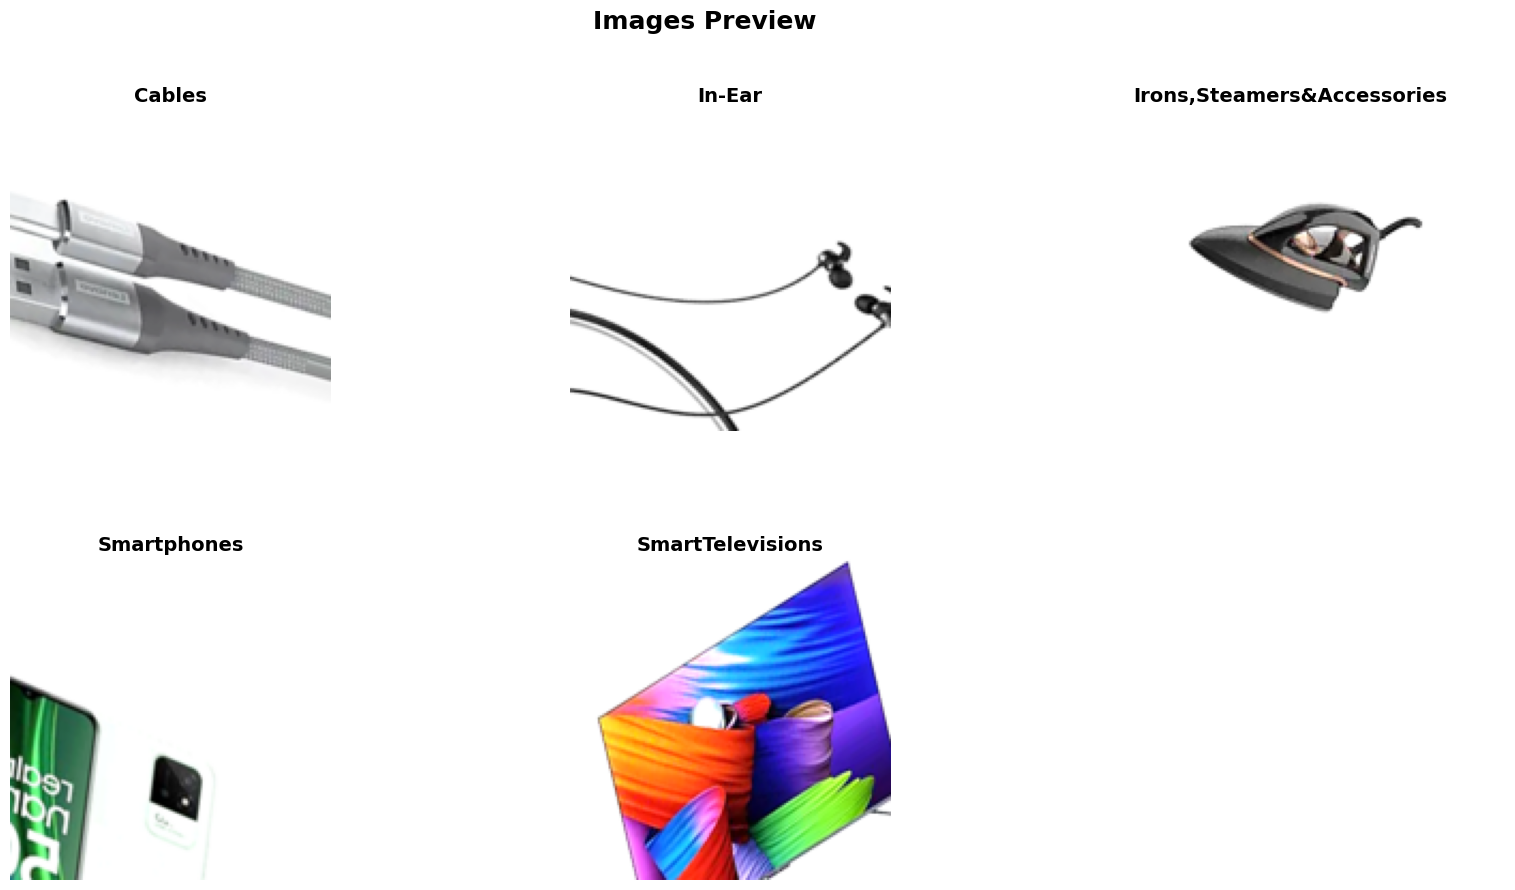

In [270]:
plt.rcParams["figure.figsize"] = (20, 10)
fig, axs = plt.subplots(2, 3, gridspec_kw={'hspace': 0.4, 'wspace': 0.3})

# Define the categories and images
categories = ['Cables', 'In-Ear', 'Irons,Steamers&Accessories', 'Smartphones', 'SmartTelevisions']
images = [cables_img, inEar_img, ironSteamerAccessories_img, smartphones_img, smartTelevisions_img]

# Iterate over the categories and images
for i, (category, category_img) in enumerate(zip(categories, images)):  
    axs[i // 3, i % 3].imshow(category_img[0])  # Display the first image of each category
    axs[i // 3, i % 3].axis('off')  # Hide axis
    axs[i // 3, i % 3].set_title(category, fontsize=14, fontweight='bold')

# Hide the unused (last) subplot
axs[1, 2].axis('off')

plt.suptitle('Images Preview', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### Process all images

In [9]:
def load_data():
    datasets = ['images_aug_2K/train', 'images_aug_2K/test']    
    output = []

    for dataset in datasets:
        images, labels = [], []
        print(f"Loading {dataset}...")

        for folder in os.listdir(dataset):
            if folder == '.DS_Store':
                continue
            label = class_label[folder]
            folder_path = os.path.join(dataset, folder)

            for file in tqdm(os.listdir(folder_path), desc=f"Processing {folder}"):
                if file == '.DS_Store':
                    continue
                img_path = os.path.join(folder_path, file)

                image = Image.open(img_path).convert('RGB').resize((150, 150))
                images.append(np.array(image))
                labels.append(label)
                
        images = np.stack(images)
        labels = np.array(labels, dtype='int32')
        output.append((images, labels))
        
    return output

In [10]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading images_aug_2K/train...


Processing Cables: 100%|██████████| 1800/1800 [00:04<00:00, 386.10it/s]


Loading images_aug_2K/test...


Processing Cables: 100%|██████████| 200/200 [00:00<00:00, 357.96it/s]


In [11]:
#Normalization
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [12]:
# Convert NumPy arrays to tensors
train_images_tensor = tf.convert_to_tensor(train_images, dtype=tf.float32)
train_labels_tensor = tf.convert_to_tensor(train_labels, dtype=tf.int32)
test_images_tensor = tf.convert_to_tensor(test_images, dtype=tf.float32)
test_labels_tensor = tf.convert_to_tensor(test_labels, dtype=tf.int32)

# Shuffle the training set
train_dataset = tf.data.Dataset.from_tensor_slices((train_images_tensor, train_labels_tensor))
train_dataset = train_dataset.shuffle(buffer_size=len(train_images_tensor))

# Shuffle the test set
test_dataset = tf.data.Dataset.from_tensor_slices((test_images_tensor, test_labels_tensor))
test_dataset = test_dataset.shuffle(buffer_size=len(test_images_tensor))

# To convert back to tensors if needed (not always necessary with tf.data.Dataset)
train_images_shuffled, train_labels_shuffled = zip(*list(train_dataset.as_numpy_iterator()))
test_images_shuffled, test_labels_shuffled = zip(*list(test_dataset.as_numpy_iterator()))

# Convert back to tensors
train_images_shuffled_tensor = tf.convert_to_tensor(train_images_shuffled, dtype=tf.float32)
train_labels_shuffled_tensor = tf.convert_to_tensor(train_labels_shuffled, dtype=tf.int32)
test_images_shuffled_tensor = tf.convert_to_tensor(test_images_shuffled, dtype=tf.float32)
test_labels_shuffled_tensor = tf.convert_to_tensor(test_labels_shuffled, dtype=tf.int32)


2024-10-27 23:01:11.728732: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-27 23:01:12.086105: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [13]:
n_train = train_labels_tensor.shape[0]
n_test = test_labels_tensor.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))

Number of training examples: 9001
Number of testing examples: 1003


## Convolutional Neural Network (CNN) Model
- A 2D convolution layer used to detect patterns such as edges or textures in images.
- MaxPooling reduces the spatial dimensions (height and width) by taking the maximum value from non-overlapping 2x2 regions.
- Dropout randomly deactivates 20% of neurons during training to prevent overfitting.
- Flatten converts the 2D feature map (75x75x32) into a 1D vector.
- Dense(5,activation = 'softmax') converts the output into probabilities for each class. 


In [34]:
model = Sequential([
    Conv2D(filters=32,kernel_size=3,activation='relu',input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=2) ,# down sampling the output instead of 28*28 it is 14*14
    Dropout(0.2),
    Flatten(), # flatten out the layers
    Dense(32,activation='relu'),
    Dense(5,activation = 'softmax') # five categories
    
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 175232)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │     5,607,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,608,517 (21.39 MB)

 Trainable params: 5,608,517 (21.39 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [277]:
history = model.fit(train_images_shuffled_tensor,
                    train_labels_shuffled_tensor,
                    batch_size=128, 
                    epochs=20,
                    validation_split = 0.2)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 445ms/step - accuracy: 0.2771 - loss: 7.6561 - val_accuracy: 0.3420 - val_loss: 1.3608
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 476ms/step - accuracy: 0.3973 - loss: 1.2892 - val_accuracy: 0.4753 - val_loss: 1.1607
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 26s 460ms/step - accuracy: 0.5365 - loss: 1.0569 - val_accuracy: 0.5036 - val_loss: 1.1112
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 29s 499ms/step - accuracy: 0.6253 - loss: 0.9285 - val_accuracy: 0.5614 - val_loss: 1.0681
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 534ms/step - accuracy: 0.6967 - loss: 0.8316 - val_accuracy: 0.5786 - val_loss: 1.0031
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 28s 495ms/step - accuracy: 0.7415 - loss: 0.7196 - val_accuracy: 0.5941 - val_loss: 0.9628
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 536ms/step - accuracy: 0.7807 - loss: 0.5977 - val_accuracy: 0.5880 - val_loss: 0.9962
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 534ms/step - accuracy: 0.8237 - loss: 0.5084 - val_accu

In [278]:
def plot_accuracy_loss(history):
    """
    Plot the accuracy and the loss during the training of the neural network.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].plot(history.history['accuracy'], 'b--o', label="Training Accuracy")
    axes[0].plot(history.history['val_accuracy'], 'r--o', label="Validation Accuracy")
    axes[0].set_title("Training vs Validation Accuracy", fontsize=14)
    axes[0].set_xlabel("Epochs", fontsize=12)
    axes[0].set_ylabel("Accuracy", fontsize=12)
    axes[0].legend(loc="lower right")
    axes[0].grid(True)

    axes[1].plot(history.history['loss'], 'b--o', label="Training Loss")
    axes[1].plot(history.history['val_loss'], 'r--o', label="Validation Loss")
    axes[1].set_title("Training vs Validation Loss", fontsize=14)
    axes[1].set_xlabel("Epochs", fontsize=12)
    axes[1].set_ylabel("Loss", fontsize=12)
    axes[1].legend(loc="upper right")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

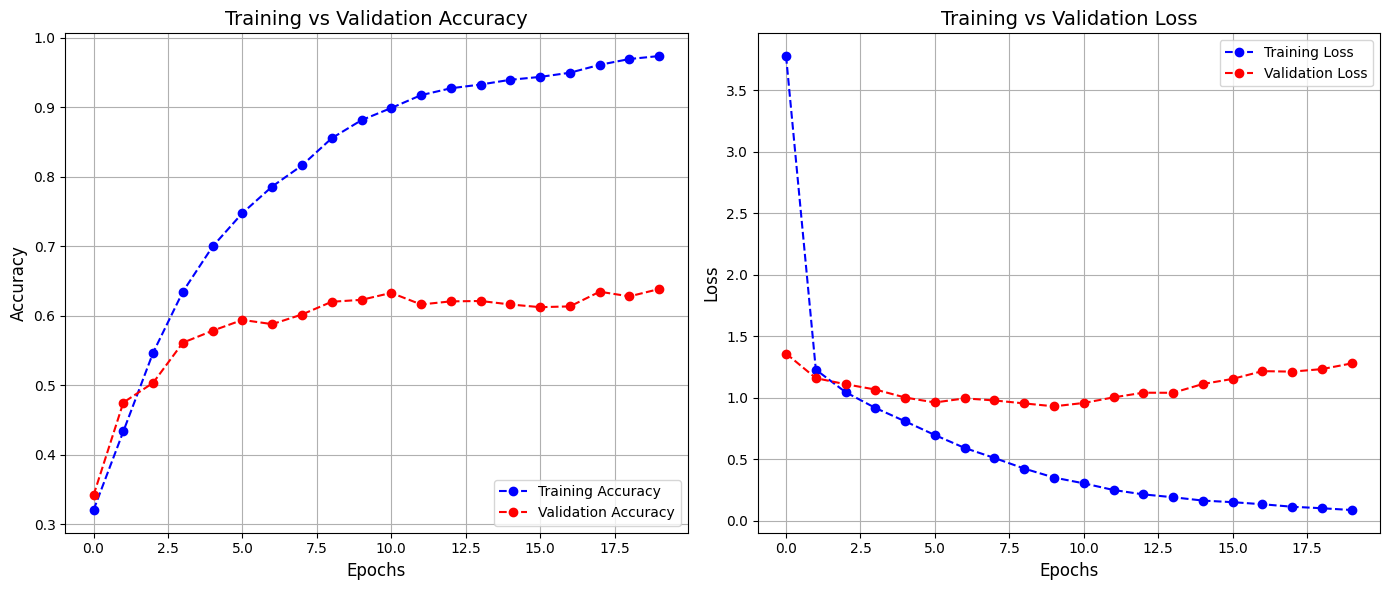

In [280]:
plot_accuracy_loss(history)

From the graphs above, the area where the training accuracy improves while validation accuracy stagnates, and where validation loss increases indicates overfitting.

Hence, early stopping is introduced to mitigae overfitting.

In [36]:
callbacks = [EarlyStopping(monitor='val_loss', patience=3)]

history = model.fit(train_images_shuffled_tensor,
                    train_labels_shuffled_tensor,
                    batch_size=128, 
                    epochs=20,
                    validation_split = 0.2,
                    callbacks=callbacks)

test_loss = model.evaluate(test_images, test_labels)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 454ms/step - accuracy: 0.2380 - loss: 3.4811 - val_accuracy: 0.4597 - val_loss: 1.2309
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 28s 482ms/step - accuracy: 0.5159 - loss: 1.1113 - val_accuracy: 0.6247 - val_loss: 0.8939
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 28s 487ms/step - accuracy: 0.6751 - loss: 0.8140 - val_accuracy: 0.5891 - val_loss: 0.8703
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 462ms/step - accuracy: 0.7494 - loss: 0.6629 - val_accuracy: 0.6258 - val_loss: 0.8431
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 28s 488ms/step - accuracy: 0.8089 - loss: 0.5474 - val_accuracy: 0.6280 - val_loss: 0.8293
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 471ms/step - accuracy: 0.8554 - loss: 0.4432 - val_accuracy: 0.6324 - val_loss: 0.8292
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 28s 484ms/step - accuracy: 0.8975 - loss: 0.3569 - val_accuracy: 0.6408 - val_loss: 0.8303
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 28s 494ms/step - accuracy: 0.9139 - loss: 0.2975 - val_accu

## Results of random test data on the trained model

In [39]:
def display_random_image(class_names, images, labels):
    index = np.random.randint(images.shape[0])
    plt.figure(figsize=(3,3))
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


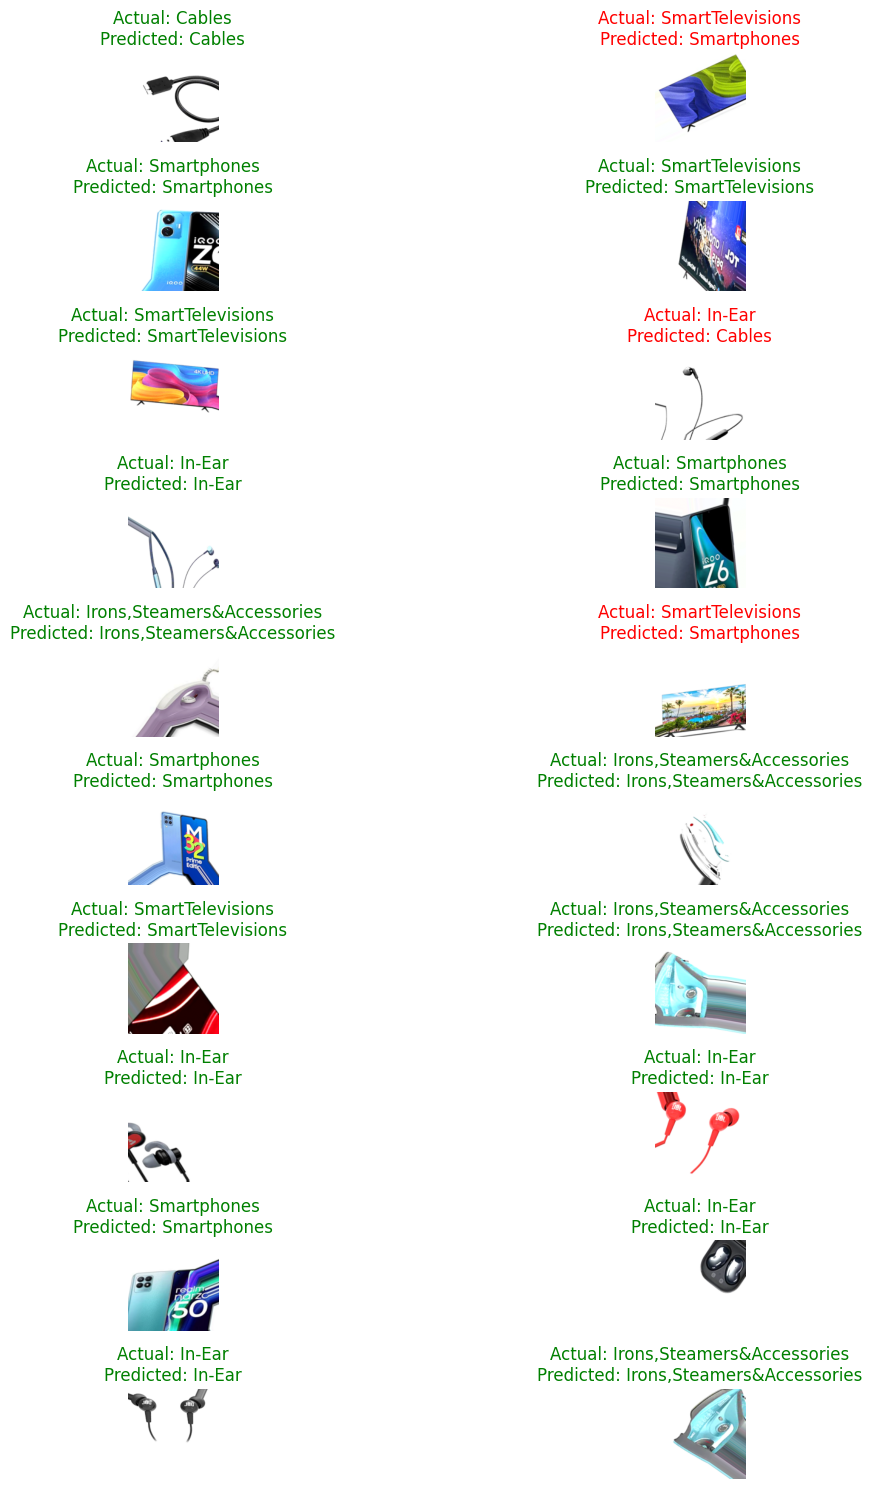

In [40]:
def display_multiple_predictions(class_names, images, labels, predictions, num_images=10):
    plt.figure(figsize=(15, 15))
    
    for i in range(num_images):

        plt.subplot(10, 2, i + 1)
        plt.imshow(images[i])
        actual_label = class_names[labels[i]]
        predicted_label = class_names[predictions[i]]
        color = 'green' if predicted_label == actual_label else 'red'
        plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}", color=color)
        plt.axis('off')  # Hide axis

    plt.tight_layout()
    plt.show()
    
# Generate predictions for the test images
predictions = model.predict(test_images)  # Vector of probabilities
pred_labels = np.argmax(predictions, axis=1)  # Take the index of the highest probability

# Shuffle the test set, labels, and predictions together
shuffled_indices = np.random.permutation(len(test_images))

shuffled_images = test_images[shuffled_indices]
shuffled_labels = test_labels[shuffled_indices]
shuffled_predictions = pred_labels[shuffled_indices]

# Display the shuffled test images with predictions
display_multiple_predictions(class_names, shuffled_images, shuffled_labels, shuffled_predictions, num_images=20)

## Metrics:
- F1 - score
- Confusion Matrix
- AUC ROC curve


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


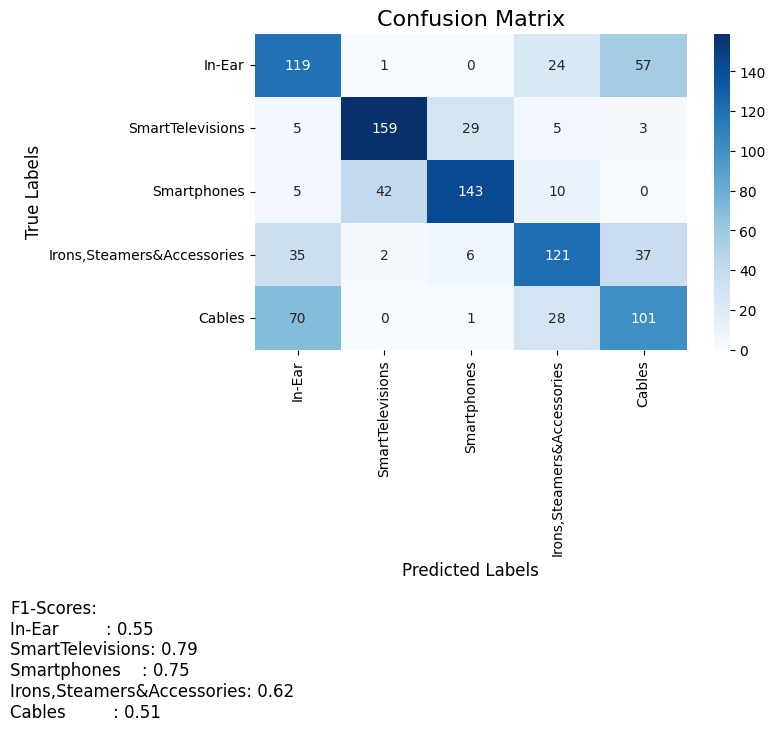

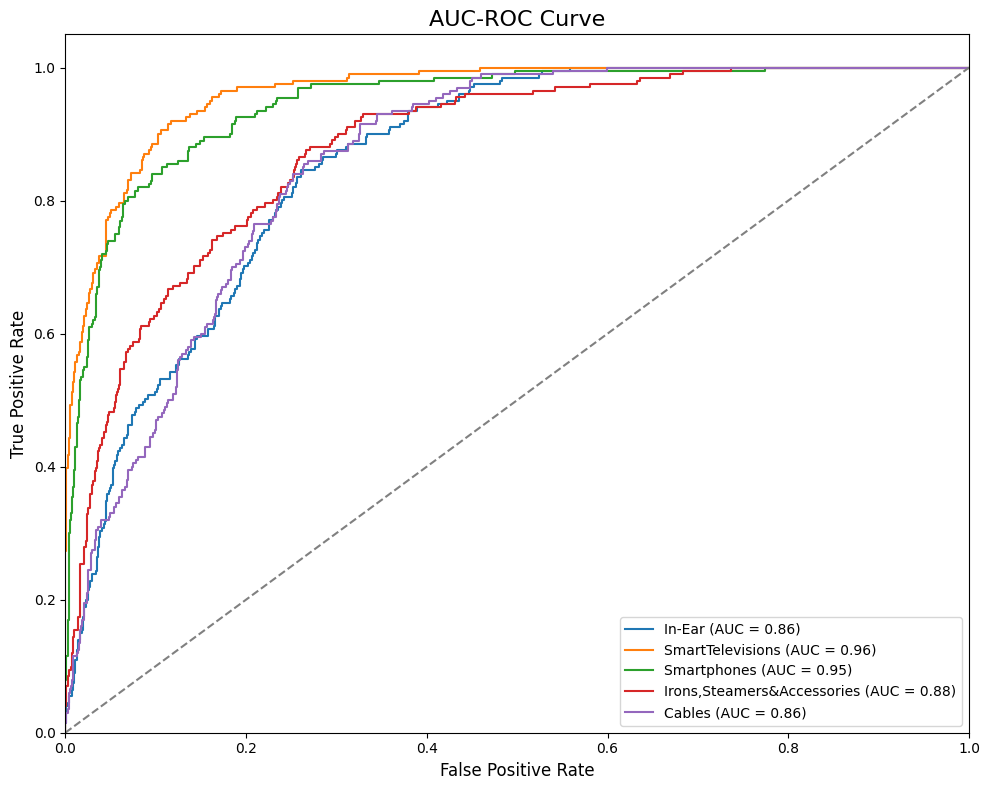

In [50]:
def plot_confusion_matrix(true_labels, pred_labels, class_names):
    """Plot the confusion matrix with nicely formatted F1-scores."""
    cm = confusion_matrix(true_labels, pred_labels)
    f1_scores = f1_score(true_labels, pred_labels, average=None)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=class_names, yticklabels=class_names)

    f1_text = "F1-Scores:\n" + "\n".join([
        f"{class_names[i]:<15}: {score:.2f}" for i, score in enumerate(f1_scores)
    ])
    
    plt.figtext(0, -0.2, f1_text, ha="left", fontsize=12, wrap=True)

    plt.title("Confusion Matrix", fontsize=16)
    plt.xlabel("Predicted Labels", fontsize=12)
    plt.ylabel("True Labels", fontsize=12)
    plt.tight_layout()
    plt.show()


def plot_auc_roc_curve(true_labels, pred_probs, class_names):
    """Plot AUC-ROC curve for each class."""
    n_classes = len(class_names)
    plt.figure(figsize=(10, 8))

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(true_labels == i, pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.title("AUC-ROC Curve", fontsize=16)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

# Example usage
predictions = model.predict(test_images)  # Model's predicted probabilities
pred_labels = np.argmax(predictions, axis=1)  # Convert to class labels

# Plot Confusion Matrix
plot_confusion_matrix(test_labels, pred_labels, class_names)

# Plot AUC-ROC Curve
plot_auc_roc_curve(test_labels, predictions, class_names)


From the above confusion matrix, we can see that the model tend to misclassify `Cables` with `In-Ears` and `Smartphones` with `SmartTelevisions`, vice-versa. 

misclassifications could be due to both product having really similar features.

For both `Cables` and `In-Ears`, the model might detect similar thin, elongated shapes (e.g., wires or cords) present in both cables and in-ear headphones. 

Both `Smartphones` and `SmartTelevisions` could have large rectangular screens.

## Saving trained model architecture and weights

In [53]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.weights.h5")
print("Saved model to disk")

Saved model to disk
